In [1]:
images_dir = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/images"
masks_dir = "/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/masks"

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os

device = 'cuda'

df = pd.read_csv('/kaggle/input/supervisely-filtered-segmentation-person-dataset/df.csv')
df.drop(['collages'],axis=1, inplace=True)
df['images'] = df['images'].apply(lambda x: '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/' + x)
df['masks'] = df['masks'].apply(lambda x: '/kaggle/input/supervisely-filtered-segmentation-person-dataset/supervisely_person_clean_2667_img/supervisely_person_clean_2667_img/' + x)
df = df.drop(df.columns[0], axis=1)
df = df.rename(columns={'images': 'image', 'masks': 'mask'})
df.head()

,image,mask
0,/kaggle/input/supervisely-filtered-segmentatio...,/kaggle/input/supervisely-filtered-segmentatio...
1,/kaggle/input/supervisely-filtered-segmentatio...,/kaggle/input/supervisely-filtered-segmentatio...
2,/kaggle/input/supervisely-filtered-segmentatio...,/kaggle/input/supervisely-filtered-segmentatio...
3,/kaggle/input/supervisely-filtered-segmentatio...,/kaggle/input/supervisely-filtered-segmentatio...
4,/kaggle/input/supervisely-filtered-segmentatio...,/kaggle/input/supervisely-filtered-segmentatio...


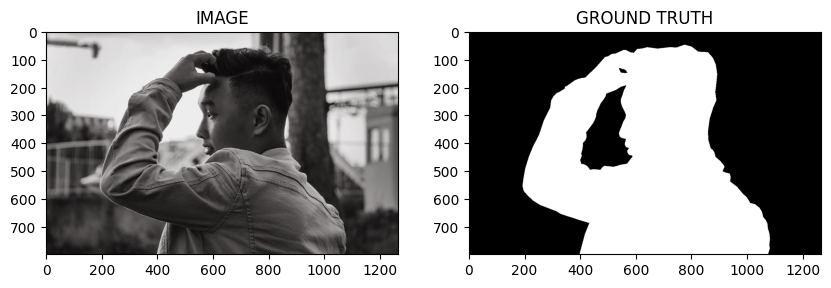

In [4]:
row = df.iloc[5]

image_path = row['image']
mask_path = row['mask']

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [5]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
import albumentations as A
from torch.utils.data import Dataset

In [7]:
def get_train_augs():
    return A.Compose([
      A.Resize(480, 640),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
    ],is_check_shapes=False)

def get_valid_augs():
    return A.Compose([
      A.Resize(480, 640),
    ],is_check_shapes=False)

In [8]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]
        image_path = row['image']
        mask_path = row['mask']

        image = cv2.imread(image_path)
       
        #_, image = cv2.threshold(image,100,255, cv2.THRESH_OTSU)
        #image = cv2.Canny(image, 60, 200)
        #image = np.expand_dims(image, axis=-1)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        b, g, r = cv2.split(image)

        # 對每個通道應用拉普拉斯遮罩
        laplacian_b = cv2.Laplacian(b, cv2.CV_64F)
        laplacian_g = cv2.Laplacian(g, cv2.CV_64F)
        laplacian_r = cv2.Laplacian(r, cv2.CV_64F)

        # 將拉普拉斯遮罩轉換為8位無符號整數數組
        laplacian_b = cv2.convertScaleAbs(laplacian_b)
        laplacian_g = cv2.convertScaleAbs(laplacian_g)
        laplacian_r = cv2.convertScaleAbs(laplacian_r)

        # 將拉普拉斯遮罩與原始圖像相加
        sharpened_b = cv2.add(b, laplacian_b)
        sharpened_g = cv2.add(g, laplacian_g)
        sharpened_r = cv2.add(r, laplacian_r)

        # 合併通道
        image = cv2.merge((sharpened_b, sharpened_g, sharpened_r))

        
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) # (h, w)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.augmentations(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # (h, w, c) -> (c, h, w)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.
        #image = torch.round(torch.Tensor(image) / 255.0)
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [9]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(val_df, get_valid_augs())

In [10]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 2133
Size of Validset : 534


In [11]:
def show_image(image,mask,pred_image = None):
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

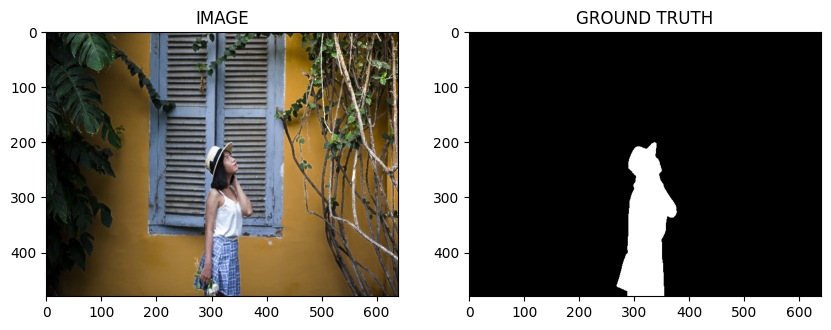

In [12]:
idx = 7
image, mask = trainset[idx]
show_image(image, mask)

In [13]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
validloader = DataLoader(validset, batch_size=4)

In [14]:
print(len(trainloader))
print(len(validloader))

534
134


In [15]:
for images, masks in trainloader:
    print(images.shape, masks.shape)
    break

torch.Size([4, 3, 480, 640]) torch.Size([4, 1, 480, 640])


In [16]:
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.9 MB/s eta 0:00:00:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8f13eade0a6bef6248837ab19174edfd65c57ddf336095765ae26fcb4c3d430d
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=dc75e50dfeeab5fc31d409c5969cdda845a8b69ece0a36b58f1c80431a1a8a75
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

## Model Define

In [17]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [18]:
import torch
import torch.nn as nn

class InitialBlock(nn.Module):
    def __init__ (self,in_channels = 3,out_channels = 13):
        super().__init__()


        self.maxpool = nn.MaxPool2d(kernel_size=2, 
                                      stride = 2, 
                                      padding = 0)

        self.conv = nn.Conv2d(in_channels, 
                                out_channels,
                                kernel_size = 3,
                                stride = 2, 
                                padding = 1)

        self.prelu = nn.PReLU(16)

        self.batchnorm = nn.BatchNorm2d(out_channels)
  
    def forward(self, x):
        
        main = self.conv(x)
        main = self.batchnorm(main)
        
        side = self.maxpool(x)
        
        x = torch.cat((main, side), dim=1)
        x = self.prelu(x)
        
        return x

class ASNeck(nn.Module):
    def __init__(self, in_channels, out_channels, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False)
        
        self.prelu1 = nn.PReLU()
        
        self.conv21 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (1, 5),
                                  stride = 1,
                                  padding = (0, 2),
                                  bias = False)
        
        self.conv22 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = (5, 1),
                                  stride = 1,
                                  padding = (2, 0),
                                  bias = False)
        
        self.prelu2 = nn.PReLU()
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = nn.PReLU()
        
        self.batchnorm1 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm3 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x):
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.prelu1(x)
        
        x = self.conv21(x)
        x = self.conv22(x)
        x = self.batchnorm2(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
                
        x = self.dropout(x)
        x = self.batchnorm3(x)
        
        # Main Branch
        
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)
        
        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

class RDDNeck(nn.Module):
    def __init__(self, dilation, in_channels, out_channels, down_flag, relu=False, projection_ratio=4, p=0.1):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        
        self.out_channels = out_channels
        self.dilation = dilation
        self.down_flag = down_flag

        if down_flag:
            self.stride = 2
            self.reduced_depth = int(in_channels // projection_ratio)
        else:
            self.stride = 1
            self.reduced_depth = int(out_channels // projection_ratio)
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                      stride = 2,
                                      padding = 0, return_indices=True)
        

        
        self.dropout = nn.Dropout2d(p=p)

        self.conv1 = nn.Conv2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               stride = 1,
                               padding = 0,
                               bias = False,
                               dilation = 1)
        
        self.prelu1 = activation
        
        self.conv2 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = self.stride,
                                  padding = self.dilation,
                                  bias = True,
                                  dilation = self.dilation)
                                  
        self.prelu2 = activation
        
        self.conv3 = nn.Conv2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  stride = 1,
                                  padding = 0,
                                  bias = False,
                                  dilation = 1)
        
        self.prelu3 = activation
        
        self.batchnorm1 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm3 = nn.BatchNorm2d(self.out_channels)
        
        
    def forward(self, x):
        
        bs = x.size()[0]
        x_copy = x
        
        # Side Branch
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.prelu1(x)
        
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.prelu2(x)
        
        x = self.conv3(x)
        x = self.batchnorm3(x)
                
        x = self.dropout(x)
        
        # Main Branch
        if self.down_flag:
            x_copy, indices = self.maxpool(x_copy)
          
        if self.in_channels != self.out_channels:
            out_shape = self.out_channels - self.in_channels
            extras = torch.zeros((bs, out_shape, x.shape[2], x.shape[3]))
            if torch.cuda.is_available():
                extras = extras.cuda()
            x_copy = torch.cat((x_copy, extras), dim = 1)

        # Sum of main and side branches
        x = x + x_copy
        x = self.prelu3(x)
        
        if self.down_flag:
            return x, indices
        else:
            return x

class UBNeck(nn.Module):
    def __init__(self, in_channels, out_channels, relu=False, projection_ratio=4):
        
        super().__init__()
        
        # Define class variables
        self.in_channels = in_channels
        self.reduced_depth = int(in_channels / projection_ratio)
        self.out_channels = out_channels
        
        
        if relu:
            activation = nn.ReLU()
        else:
            activation = nn.PReLU()
        
        self.unpool = nn.MaxUnpool2d(kernel_size = 2,
                                     stride = 2)
        
        self.main_conv = nn.Conv2d(in_channels = self.in_channels,
                                    out_channels = self.out_channels,
                                    kernel_size = 1)
        
        self.dropout = nn.Dropout2d(p=0.1)
        
        self.convt1 = nn.ConvTranspose2d(in_channels = self.in_channels,
                               out_channels = self.reduced_depth,
                               kernel_size = 1,
                               padding = 0,
                               bias = False)
        
        
        self.prelu1 = activation
        
        self.convt2 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.reduced_depth,
                                  kernel_size = 3,
                                  stride = 2,
                                  padding = 1,
                                  output_padding = 1,
                                  bias = False)
        
        self.prelu2 = activation
        
        self.convt3 = nn.ConvTranspose2d(in_channels = self.reduced_depth,
                                  out_channels = self.out_channels,
                                  kernel_size = 1,
                                  padding = 0,
                                  bias = False)
        
        self.prelu3 = activation
        
        self.batchnorm1 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm2 = nn.BatchNorm2d(self.reduced_depth)
        self.batchnorm3 = nn.BatchNorm2d(self.out_channels)
        
    def forward(self, x, indices):
        x_copy = x
        
        # Side Branch
        x = self.convt1(x)
        x = self.batchnorm1(x)
        x = self.prelu1(x)
        
        x = self.convt2(x)
        x = self.batchnorm2(x)
        x = self.prelu2(x)
        
        x = self.convt3(x)
        x = self.batchnorm3(x)
        
        x = self.dropout(x)
        
        # Main Branch
        
        x_copy = self.main_conv(x_copy)
        x_copy = self.unpool(x_copy, indices, output_size=x.size())
        
        # Concat
        x = x + x_copy
        x = self.prelu3(x)
        
        return x

class ENet(nn.Module):
    def __init__(self, C):
        super().__init__()
        
        # Define class variables
        self.C = C
        
        # The initial block
        self.init = InitialBlock()
        
        
        # The first bottleneck
        self.b10 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=64, 
                           down_flag=True, 
                           p=0.01)
        
        self.b11 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b12 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b13 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        self.b14 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           p=0.01)
        
        
        # The second bottleneck
        self.b20 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=128, 
                           down_flag=True)
        
        self.b21 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b22 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b23 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b24 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b25 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b26 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b27 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b28 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The third bottleneck
        self.b31 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b32 = RDDNeck(dilation=2, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b33 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b34 = RDDNeck(dilation=4, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b35 = RDDNeck(dilation=1, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b36 = RDDNeck(dilation=8, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        self.b37 = ASNeck(in_channels=128, 
                          out_channels=128)
        
        self.b38 = RDDNeck(dilation=16, 
                           in_channels=128, 
                           out_channels=128, 
                           down_flag=False)
        
        
        # The fourth bottleneck
        self.b40 = UBNeck(in_channels=128, 
                          out_channels=64, 
                          relu=True)
        
        self.b41 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        self.b42 = RDDNeck(dilation=1, 
                           in_channels=64, 
                           out_channels=64, 
                           down_flag=False, 
                           relu=True)
        
        
        # The fifth bottleneck
        self.b50 = UBNeck(in_channels=64, 
                          out_channels=16, 
                          relu=True)
        
        self.b51 = RDDNeck(dilation=1, 
                           in_channels=16, 
                           out_channels=16, 
                           down_flag=False, 
                           relu=True)
        
        
        # Final ConvTranspose Layer
        self.fullconv = nn.ConvTranspose2d(in_channels=16, 
                                           out_channels=self.C, 
                                           kernel_size=3, 
                                           stride=2, 
                                           padding=1, 
                                           output_padding=1,
                                           bias=False)
        
        
    def forward(self, x):
        
        # The initial block
        x = self.init(x)
        
        # The first bottleneck
        x, i1 = self.b10(x)
        x = self.b11(x)
        x = self.b12(x)
        x = self.b13(x)
        x = self.b14(x)
        
        # The second bottleneck
        x, i2 = self.b20(x)
        x = self.b21(x)
        x = self.b22(x)
        x = self.b23(x)
        x = self.b24(x)
        x = self.b25(x)
        x = self.b26(x)
        x = self.b27(x)
        x = self.b28(x)
        
        # The third bottleneck
        x = self.b31(x)
        x = self.b32(x)
        x = self.b33(x)
        x = self.b34(x)
        x = self.b35(x)
        x = self.b36(x)
        x = self.b37(x)
        x = self.b38(x)
        
        # The fourth bottleneck
        x = self.b40(x, i2)
        x = self.b41(x)
        x = self.b42(x)
        
        # The fifth bottleneck
        x = self.b50(x, i1)
        x = self.b51(x)
        
        # Final ConvTranspose Layer
        x = self.fullconv(x)
        
        return x

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

__all__ = ["DABNet"]


class Conv(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride, padding, dilation=(1, 1), groups=1, bn_acti=False, bias=False):
        super().__init__()

        self.bn_acti = bn_acti

        self.conv = nn.Conv2d(nIn, nOut, kernel_size=kSize,
                              stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=bias)

        if self.bn_acti:
            self.bn_prelu = BNPReLU(nOut)

    def forward(self, input):
        output = self.conv(input)

        if self.bn_acti:
            output = self.bn_prelu(output)

        return output


class BNPReLU(nn.Module):
    def __init__(self, nIn):
        super().__init__()
        self.bn = nn.BatchNorm2d(nIn, eps=1e-3)
        self.acti = nn.PReLU(nIn)

    def forward(self, input):
        output = self.bn(input)
        output = self.acti(output)

        return output


class DABModule(nn.Module):
    def __init__(self, nIn, d=1, kSize=3, dkSize=3):
        super().__init__()

        self.bn_relu_1 = BNPReLU(nIn)
        self.conv3x3 = Conv(nIn, nIn // 2, kSize, 1, padding=1, bn_acti=True)

        self.dconv3x1 = Conv(nIn // 2, nIn // 2, (dkSize, 1), 1,
                             padding=(1, 0), groups=nIn // 2, bn_acti=True)
        self.dconv1x3 = Conv(nIn // 2, nIn // 2, (1, dkSize), 1,
                             padding=(0, 1), groups=nIn // 2, bn_acti=True)
        self.ddconv3x1 = Conv(nIn // 2, nIn // 2, (dkSize, 1), 1,
                              padding=(1 * d, 0), dilation=(d, 1), groups=nIn // 2, bn_acti=True)
        self.ddconv1x3 = Conv(nIn // 2, nIn // 2, (1, dkSize), 1,
                              padding=(0, 1 * d), dilation=(1, d), groups=nIn // 2, bn_acti=True)

        self.bn_relu_2 = BNPReLU(nIn // 2)
        self.conv1x1 = Conv(nIn // 2, nIn, 1, 1, padding=0, bn_acti=False)

    def forward(self, input):
        output = self.bn_relu_1(input)
        output = self.conv3x3(output)

        br1 = self.dconv3x1(output)
        br1 = self.dconv1x3(br1)
        br2 = self.ddconv3x1(output)
        br2 = self.ddconv1x3(br2)

        output = br1 + br2
        output = self.bn_relu_2(output)
        output = self.conv1x1(output)

        return output + input


class DownSamplingBlock(nn.Module):
    def __init__(self, nIn, nOut):
        super().__init__()
        self.nIn = nIn
        self.nOut = nOut

        if self.nIn < self.nOut:
            nConv = nOut - nIn
        else:
            nConv = nOut

        self.conv3x3 = Conv(nIn, nConv, kSize=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.bn_prelu = BNPReLU(nOut)

    def forward(self, input):
        output = self.conv3x3(input)

        if self.nIn < self.nOut:
            max_pool = self.max_pool(input)
            output = torch.cat([output, max_pool], 1)

        output = self.bn_prelu(output)

        return output


class InputInjection(nn.Module):
    def __init__(self, ratio):
        super().__init__()
        self.pool = nn.ModuleList()
        for i in range(0, ratio):
            self.pool.append(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, input):
        for pool in self.pool:
            input = pool(input)

        return input


class DABNet(nn.Module):
    def __init__(self, classes=19, block_1=3, block_2=6):
        super().__init__()
        self.init_conv = nn.Sequential(
            Conv(3, 32, 3, 2, padding=1, bn_acti=True),
            Conv(32, 32, 3, 1, padding=1, bn_acti=True),
            Conv(32, 32, 3, 1, padding=1, bn_acti=True),
        )

        self.down_1 = InputInjection(1)  # down-sample the image 1 times
        self.down_2 = InputInjection(2)  # down-sample the image 2 times
        self.down_3 = InputInjection(3)  # down-sample the image 3 times

        self.bn_prelu_1 = BNPReLU(32 + 3)

        # DAB Block 1
        self.downsample_1 = DownSamplingBlock(32 + 3, 64)
        self.DAB_Block_1 = nn.Sequential()
        for i in range(0, block_1):
            self.DAB_Block_1.add_module("DAB_Module_1_" + str(i), DABModule(64, d=2))
        self.bn_prelu_2 = BNPReLU(128 + 3)

        # DAB Block 2
        dilation_block_2 = [4, 4, 8, 8, 16, 16]
        self.downsample_2 = DownSamplingBlock(128 + 3, 128)
        self.DAB_Block_2 = nn.Sequential()
        for i in range(0, block_2):
            self.DAB_Block_2.add_module("DAB_Module_2_" + str(i),
                                        DABModule(128, d=dilation_block_2[i]))
        self.bn_prelu_3 = BNPReLU(256 + 3)

        self.classifier = nn.Sequential(Conv(259, classes, 1, 1, padding=0))

    def forward(self, input):

        output0 = self.init_conv(input)

        down_1 = self.down_1(input)
        down_2 = self.down_2(input)
        down_3 = self.down_3(input)

        output0_cat = self.bn_prelu_1(torch.cat([output0, down_1], 1))

        # DAB Block 1
        output1_0 = self.downsample_1(output0_cat)
        output1 = self.DAB_Block_1(output1_0)
        output1_cat = self.bn_prelu_2(torch.cat([output1, output1_0, down_2], 1))

        # DAB Block 2
        output2_0 = self.downsample_2(output1_cat)
        output2 = self.DAB_Block_2(output2_0)
        output2_cat = self.bn_prelu_3(torch.cat([output2, output2_0, down_3], 1))

        out = self.classifier(output2_cat)
        out = F.interpolate(out, input.size()[2:], mode='bilinear', align_corners=False)

        return out

In [19]:
# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(DoubleConv, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#         )

#     def forward(self, x):
#         return self.conv(x)


## Model Train

In [26]:
#model = ENet(1).to(device)
model = DABNet(classes = 1).to(device)

In [21]:
#print(model)

In [20]:
from segmentation_models_pytorch.losses import DiceLoss
loss1 = DiceLoss(mode='binary')
loss2 = nn.BCEWithLogitsLoss()

In [21]:
def train_fn(data_loader, model, optimizer):

    model.train()
    train_total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        logits = model(images)
        
        dice_loss = loss1(logits, masks)
        binary_loss = loss2(logits, masks)
        total_loss = dice_loss + binary_loss
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        train_total_loss += total_loss.item()
    scheduler.step()

    return train_total_loss / len(data_loader)

In [22]:
def eval_fn(data_loader, model):

    model.eval()
    eval_total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits = model(images)
            dice_loss = loss1(logits, masks)
            binary_loss = loss2(logits, masks)
            total_loss = dice_loss + binary_loss

            eval_total_loss += total_loss.item()

        return eval_total_loss / len(data_loader)

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
lambda1 = lambda epoch: 0.65 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

NameError: name 'model' is not defined

In [26]:
best_valid_loss = np.Inf

EPOCHS = 30
train_losses = []
val_losses = []

for i in range(EPOCHS):
    train_loss = train_fn(trainloader, model, optimizer)
    valid_loss = eval_fn(validloader, model)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best-model.pt')
        print('model saved')
        best_valid_loss = valid_loss
        

    print(f'epoch: {i+1}, train loss: {train_loss}, valid loss: {valid_loss}')

100%|██████████| 134/134 [01:10<00:00,  1.89it/s]


model saved
epoch: 1, train loss: 0.9449351337295346, valid loss: 1.1963119062025156


 98%|█████████▊| 522/534 [03:35<00:04,  2.43it/s]


KeyboardInterrupt: 

In [24]:
plt.plot(range(1, EPOCHS+1), train_losses)
plt.plot(range(1, EPOCHS+1), val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

NameError: name 'EPOCHS' is not defined

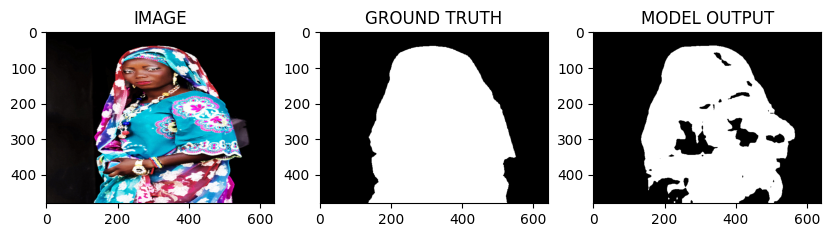

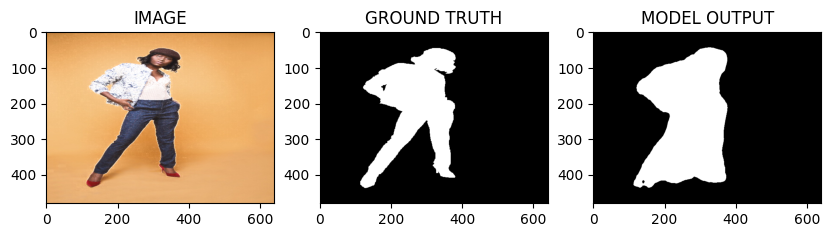

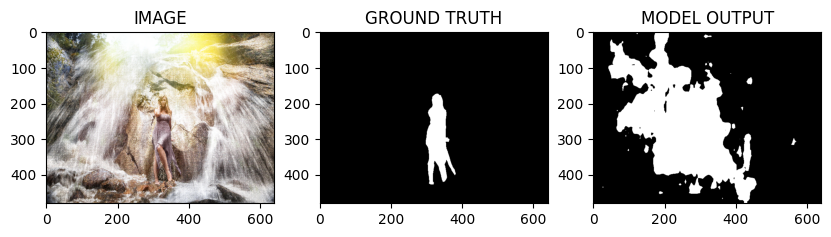

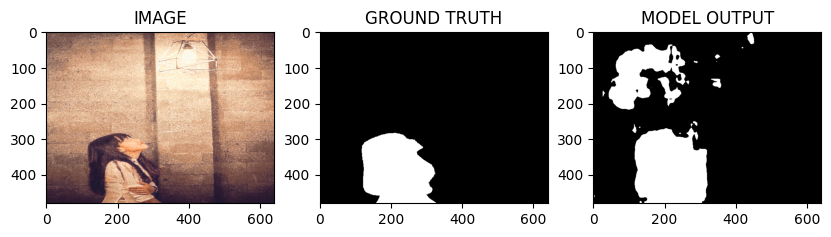

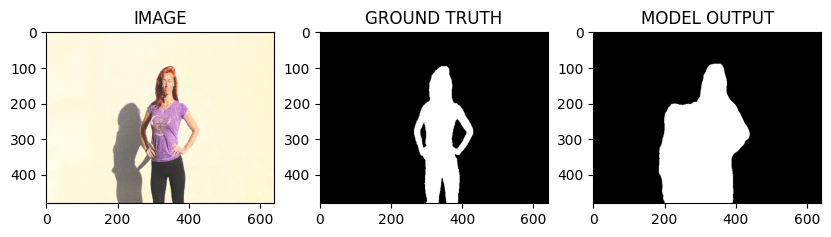

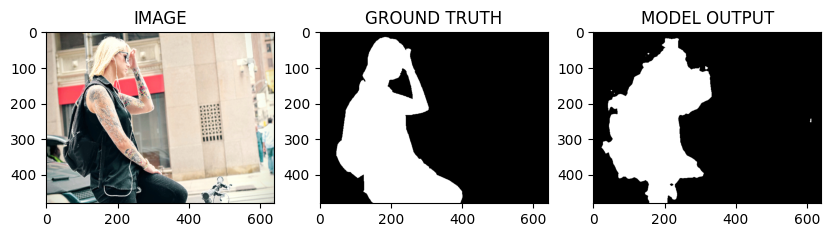

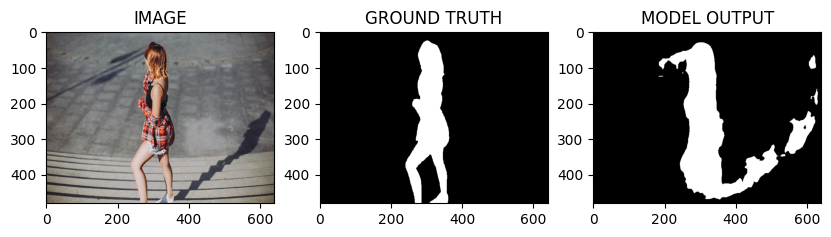

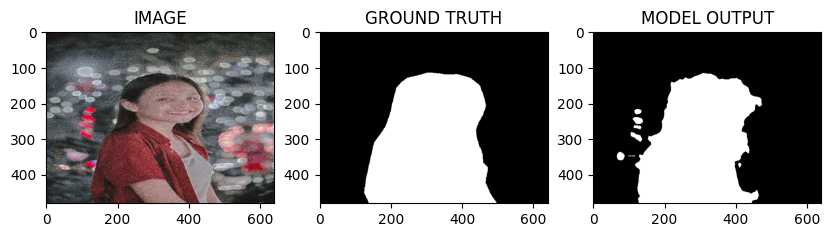

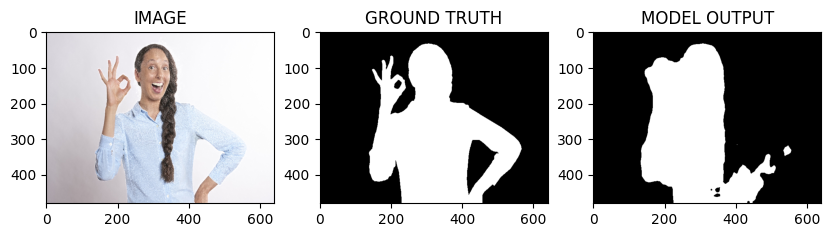

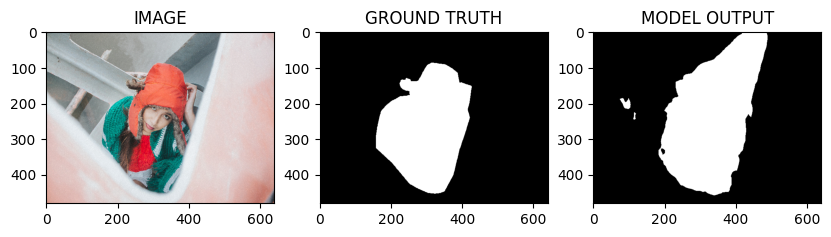

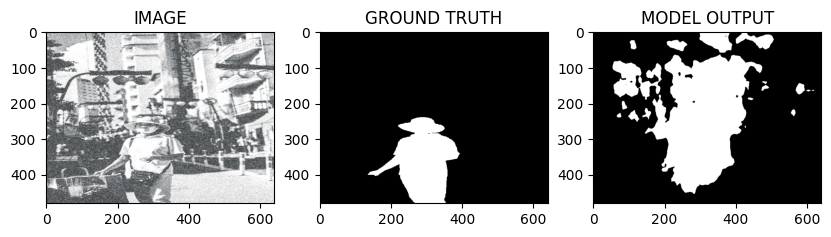

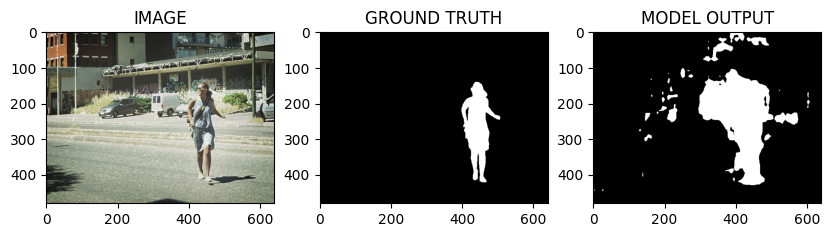

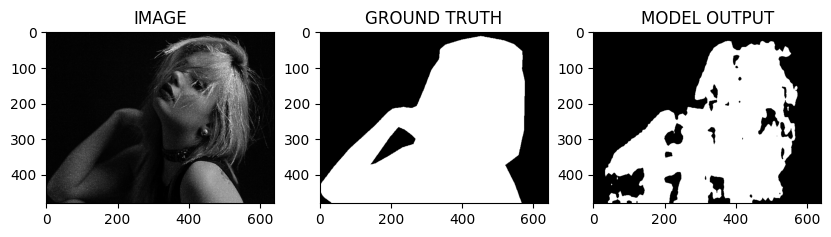

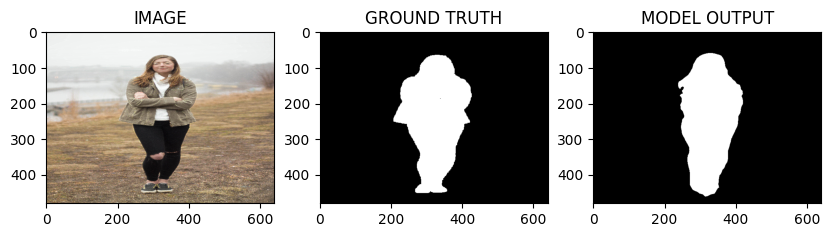

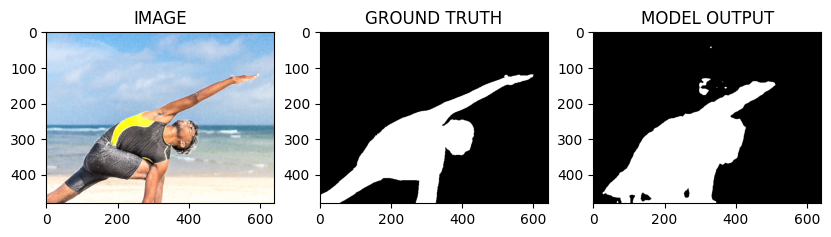

In [30]:
idx = 1

for idx in range(1, 16):
    model.load_state_dict(torch.load('/kaggle/input/dabnet/best-model.pt'))

    image, mask = validset[idx]

    logits_mask = model(image.to(device).unsqueeze(0)) # (chw) -> (1,chw)
    pred_mask = torch.sigmoid(logits_mask)

    pred_mask = (pred_mask > 0.55) * 1.0
    
    show_image(image, mask, pred_mask.detach().cpu().squeeze(0))